In [ ]:
!pip install investpy
import pandas as pd 
import investpy 
from collections import defaultdict
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import *
from math import *
import warnings
from sklearn import preprocessing
def norml(data):
  x = np.array(data).reshape(-1,1) #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  return x_scaled
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

# **Лабораторная работа №1 «Анализ данных фондового рынка»**
Мартиросян Елизавета, Максимов Антон

## Задание 1
<em> Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка. </em>


---



Данные акций и индексов взяты с сайта investing.com и скачены с помощью библиотеки https://github.com/alvarobartt/investpy.

### Акции

In [ ]:
stocks_list = investpy.get_stocks_list(country='Russia')
stocks = {}
for i in range(0, len(stocks_list)): #ticker_names
    try:
        stocks[stocks_list[i]] = investpy.get_stock_historical_data(stock=stocks_list[i],
                                                                    country='Russia',
                                                                    from_date='01/01/2018',
                                                                    to_date='31/12/2018', 
                                                                    order='ascending',)
    except IndexError:
        stocks[stocks_list[i]] = pd.DataFrame(columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Currency'])


### Информация о акциях

In [ ]:
file = open("russia.txt")
stocks_info = {}
for line in file:
  strs = line.split(':;:')
  name = strs[0][(strs[0].rfind('(') + 1) : (len(strs[0]) - 1)]
  stocks_info[name] = [strs[0], strs[1], strs[2]]
file.close()

In [ ]:
def getStocksOverview(stocks):
  stocks_overview = []
  R = getR(stocks)
  E = getE(R)
  D = getD(R)

  for key, value in stocks.items():
    try:
      full_name = stocks_info[key][0]
      sec = stocks_info[key][1]
      sector = stocks_info[key][2]
      stocks_overview.append([key, full_name, sector[sector.find(' '):], int(value['Volume'].mean()), 
                              E[key], D[key]])
    except:
      stocks_overview.append([key, key, "-", int(value['Volume'].mean()), E[key], D[key]])
      
  df = pd.DataFrame(stocks_overview, columns=["Тикер", "Полное имя","Сектор",
                                              "Средний объем","Средняя доходность","std"])
  return df

### Индексы рынка

In [ ]:
indices_list = ['MOEX', 'RTSI', 'MOEX 10', 'MOEX Blue Chip', 'Russian VIX', ]

In [ ]:
indices = {}

for i in indices_list:
  indices[i] = investpy.indices.get_index_historical_data(index=i, 
                                            country='Russia', 
                                            from_date='01/01/2018', 
                                            to_date='31/12/2018', 
                                            as_json=False, 
                                            order='ascending', 
                                            interval='Daily')

### Preprocessing

In [ ]:
unproc_stocks = stocks 


copy = stocks.copy()

for key, value in copy.items():
  if len(copy[key]['Close']) < 230:
    del stocks[key]

main_index = stocks['AFLT'].index.copy()
for key, value in stocks.items():
  stocks[key] = stocks[key].reindex(main_index)
  stocks[key]['Close'].interpolate(method='linear', inplace=True, limit = 21, limit_direction='both')
  stocks[key]['Volume'].interpolate(method='linear', inplace=True, limit = 21, limit_direction='both')


## Задание 2
<em> Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат $(σ, E)$. </em>


---




### Доходность

Доходность актива в $t$-ый день вычитывается по формуле $R_t = \ln \frac{P(t)}{P(t - 1)}$, где $P(t)$ - цена актива в день $t$.

In [ ]:
def getR(assets):
  R = defaultdict(list)

  for key, value in assets.items():
      for i in range(1, len(assets[key]['Close'])):
          R[key].append(log(float(assets[key]['Close'][i])) - log(float(assets[key]['Close'][i-1])))
  
  return R

### Математическое ожидание и стандартное отклонение

 Функция mean() вычисляет среднее арифметическое значений элементов массива. 
 
 Функция std() вычисляет среднеквадратичное (стандартное) отклонение значений элементов массива $a_1, \dots,a_n$:

$$ \sigma = \sqrt{ \frac{1}{n} \sum_{i = 1}^n  (a_i - \overline{a})^2 }, $$
где $\overline{a}$ - это среднее арифметическое чисел $a_1, \dots,a_n$.

In [ ]:
def getE(R): #вычисление мат-ожидания
  E = {}
  for key, value in R.items():
    E[key] = np.mean(R[key])
  return E
  
def getD(R): #вычисление стандартного отклонения
  D = {}
  for key, value in R.items():
    D[key] = np.std(R[key])
  return D

### Карта активов

In [ ]:
def draw(D, E, XX=None, YY=None, ax=None, LABELS=None, zoom=True):

  if ax == None:
    fig, ax = plt.subplots(1, figsize=(10,6), dpi=150)
    fig.subplots_adjust(left=0.5, bottom=0.3)
  
  X1, X2, Y1, Y2 = [], [], [], []

  for key, value in E.items():
    if value >= 0:
      X1.append(D[key])
      Y1.append(value)
    else:
      X2.append(D[key])
      Y2.append(value)
  
  ax.scatter(X1, Y1, s=20, marker = 'o', alpha = 0.7, color='green')
  ax.scatter(X2, Y2, s=20, marker = 'o', alpha = 0.7, color='red')
  
  if XX is not None:
    ax.scatter(XX.values(), YY.values(), s=120, marker = '*', color='blue', alpha = 0.7)
    for key, value in XX.items():
      ax.text(XX[key]+0.001, YY[key]+0.0001, s = key)
      
  if LABELS is None:
    ax.text(D['NVTK'],E['NVTK'], s = 'NVTK')
    ax.text(D['IRKT'],E['IRKT'], s = 'IRKT')
    ax.text(D['MSST'],E['MSST'], s = 'MSST')
    ax.text(D['DVEC'],E['DVEC'], s = 'DVEC')
    ax.text(D['RKKE'],E['RKKE'], s = 'RKKE')
    ax.text(D['TANL'],E['TANL'], s = 'TANL')
    ax.text(D['MGVM'],E['MGVM'], s = 'MGVM')
    ax.text(D['SIBG'],E['SIBG'], s = 'SIBG')
    ax.text(D['TUCH'],E['TUCH'], s = 'TUCH')
  else:
    for key in LABELS:
      ax.text(D[key], E[key], s=key)

  plt.xlabel('σ')
  plt.ylabel('E')

  if zoom:    
    axins = zoomed_inset_axes(ax, 2, loc='lower left', bbox_to_anchor=(0,0), borderpad=3)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    axins.set_xlim([0.005,0.033])
    axins.set_ylim([-0.0026,0.0022])
    axins.set_xlabel('σ')
    axins.set_ylabel('E')
    axins.scatter(X1, Y1, s=50, marker = 'o', color='green', alpha = 0.7)
    axins.scatter(X2, Y2, s=50, marker = 'o', color='red', alpha = 0.7)

    if XX is not None:
      axins.scatter(XX.values(), YY.values(), s=180, marker = '*', color='blue', alpha = 0.7)
      for key, value in XX.items():
        if XX[key] < 0.033 and YY[key] < 0.0022:
          axins.text(XX[key]+0.001, YY[key]+0.0001, s = key)


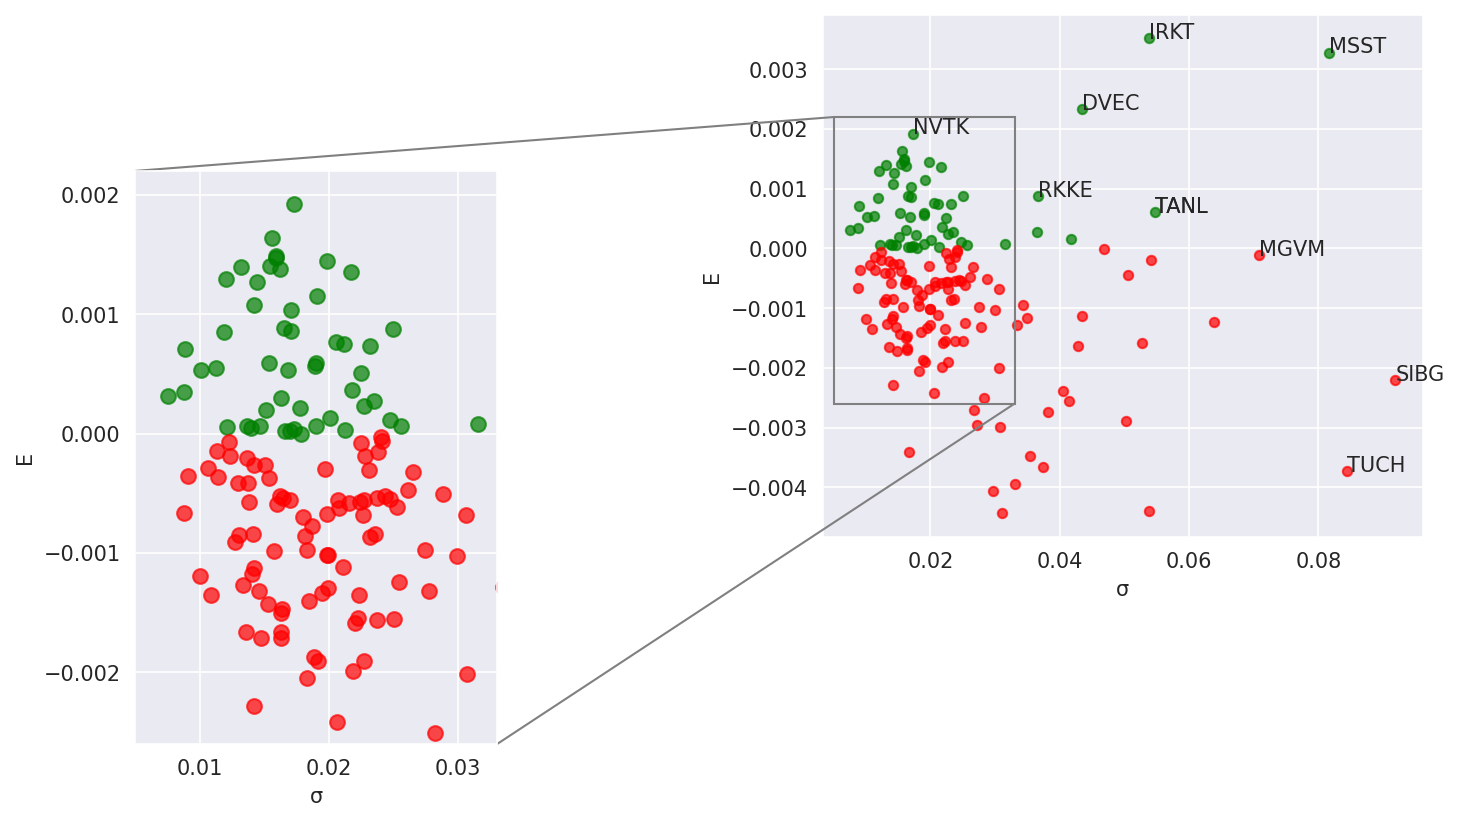

In [ ]:
R = getR(stocks)
draw(getD(R), getE(R))
plt.show()

***Оценка математического ожидания большинства активов находится в диапазоне [-0.002;0.002], а стандартное отклонение [0, 0.03].***

Список отмеченных активов:

In [ ]:
lst = np.array(['NVTK', 'IRKT', 'MSST', 'DVEC', 'RKKE', 'TANL', 'MGVM', 'SIBG', 'TUCH'])
for key in lst:
  try:
    print(stocks_info[key])
  except:
    print(key)

['ОАО НОВАТЭК (NVTK)', 'Отрасль Интегрированная нефтегазовая промышленность', 'Сектор Энергетика']
['Корпорация Иркут (IRKT)', 'Отрасль Аэрокосмическая и оборонная промышленность', 'Сектор Средства производства']
['Мультисистема OAO (MSST)', 'Отрасль Строительные услуги', 'Сектор Средства производства']
['ДЭК ОАО (DVEC)', 'Отрасль Электроэнергетика', 'Сектор Коммунальные услуги']
['РКК Энергия ОАО (RKKE)', 'Отрасль Аэрокосмическая и оборонная промышленность', 'Сектор Средства производства']
['Тантал (TANL)', 'Отрасль Аэрокосмическая и оборонная промышленность', 'Сектор Средства производства']
MGVM
['Сибирский гостинец (SIBG)', 'Отрасль Пищевая промышленность', 'Сектор Нецикличные компании']
['Тучковский комбинат строительных материалов (TUCH)', 'Отрасль Строительство - сырье', 'Сектор Средства производства']


## Задание 3
<em> Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат $(σ, E)$.  Дайте характеристику этому портфелю.</em>


---



In [ ]:
R = getR(stocks)
E = getE(R)

<em>Для подсчета характеристик портфеля использовалась формула:</em>

$$ risk = \frac{ \sum_{i = 1}^n \sum_{j = 1}^n \sigma_{i,j} }{N^2} $$

In [ ]:
risk = sqrt(float(np.cov(list(R.values())).sum() / (172**2)))
mean = sum(list(E.values()))/172
print('mean:', mean, 'risk:', risk)

mean: -0.0005836974722313317 risk: 0.007188328709556228


**А можно так**

$$Porfolio\ Standard\ Deviation = \sqrt{weights^T . (covariance\ matrix) . weights}$$

In [ ]:
def generate_portfolio(returns):
    w = np.ones((1,172))*(1/172)
    cov_matrix = np.asmatrix(np.cov(returns))
    positions = np.asmatrix(np.mean(returns, axis=1))
    mean = w * positions.T
    risk = np.sqrt(w * cov_matrix * w.T)
    return float(mean), float(risk)

In [ ]:
generate_portfolio(list(R.values()))

(-0.0005814084625363066, 0.0071742576187907485)

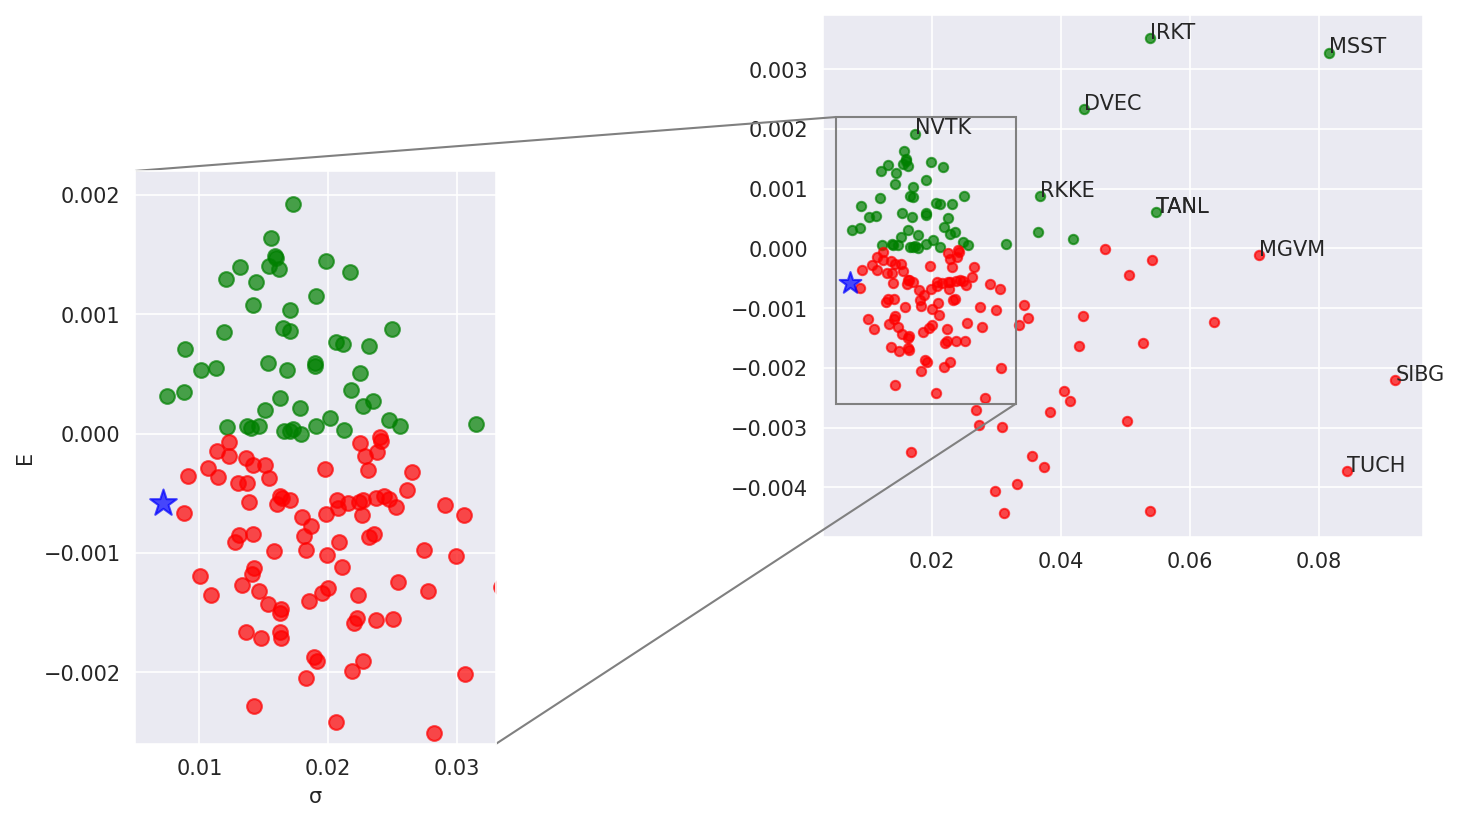

In [ ]:
mean, risk = generate_portfolio(list(R.values()))
draw(getD(R), getE(R), {' ':risk}, {' ':mean})
plt.show()

**Портфель, который не жалко потерять**

## Задание 4
<em> Рассмотрите индекс рынка и отметьте его на карте активов в системе координат $(σ, E)$. Дайте характеристику индексу рынка. </em>


---




Для анализа были взяты 5 основных индекса рынка России, а именно: MOEX, RTSI, MOEX 10, MOEX Blue Chip, Russian VIX. 
Подробную информацию о индексах можно найти на официальном сайте https://www.moex.com/ru/factsheet.

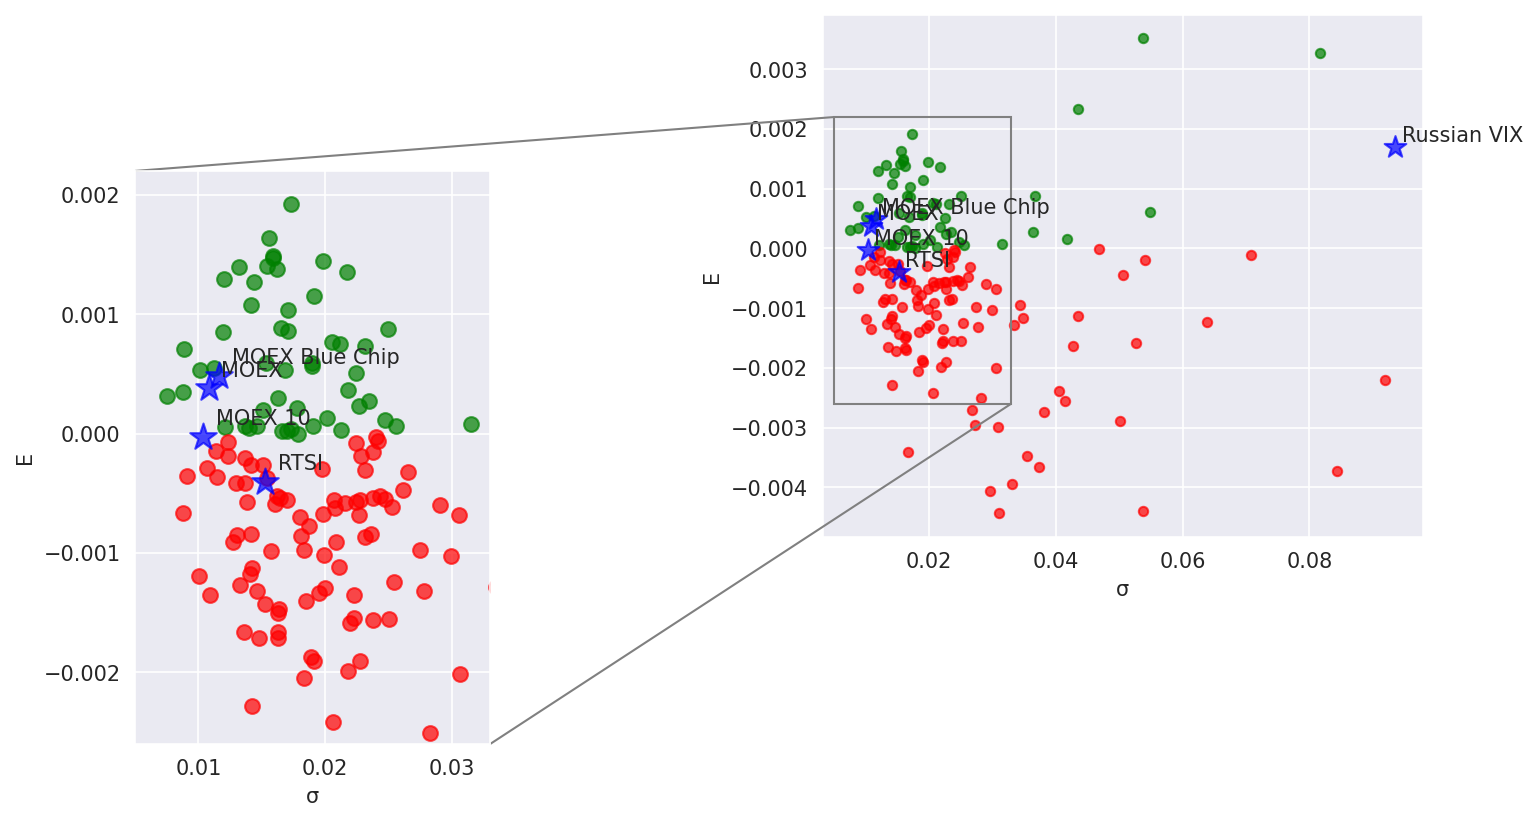

In [ ]:
R_indices = getR(indices)
R = getR(stocks)
draw(getD(R), getE(R), getD(R_indices), getE(R_indices), LABELS={})

<b>RTSI, MOEX</b> - индексы российского фондового рынка,включающий наиболее ликвидные акции крупнейших и динамично развивающихся российских эмитентов.

<b>Индекс МосБиржи голубых фишек (MOEX Blue Chip)</b> является индикатором рынка наиболее ликвидных акций российских компаний или так называемых "голубых фишек". Индекс рассчитывается на основании цен сделок и котировок наиболее ликвидных акций 15-ти эмитентов российского фондового рынка.

<b>Индекс МосБиржи 10</b> представляет собой композитный ценовой равновзвешенный индекс 10 наиболее ликвидных акций фондового рынка Московской Биржи. Индекс рассчитывается как среднее арифметическое изменения цен акций, включенных в Базу расчета.

<b>Индекс волатильности российского рынка (RVI)</b> - индикатор срочного рынка, который рассчитывается на основе волатильности фактических цен опционов на Индекс РТС. При расчёте индекса, используются цены ближайшей и следующей за ней серий опционов со сроком до экспирации более 30 дней.

Топ 10 акций, входящие в индексы MOEX, MOEX 10, RTSI, MOEX Blue Chip на 2018 год:
<ol>
<li>ЛУКОЙЛ (LKOH)</li>
<li>Роснефть (ROSN)</li>
<li>Газпром (GAZP)</li>
<li>Банк ВТБ ОАО(VTBR)</li>
<li>Сбербанк (SBER)</li>
<li>ОАО АК АЛРОСА (ALRS)</li>
<li>Сбербанк прев. (SBER_p)</li>
<li>Норильский никель (GMKN)</li>
<li>Московская биржа ОАО ММВБ (MOEX)</li>    
<li>ОАО Магнит (MGNT)</li>
</ol>

Отметим их на карте активов:

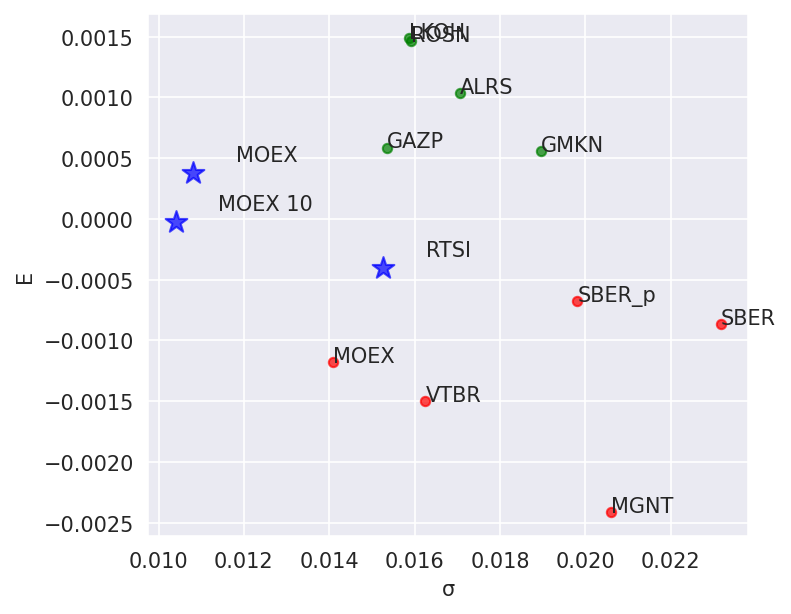

In [ ]:
R = getR(stocks)
RI = getR({'MOEX': indices['MOEX'], 'MOEX 10': indices['MOEX 10'], 'RTSI': indices['RTSI'], 
           'MOEX Blue Chip': indices['MOEX Blue Chip']})
E, D = getE(R), getD(R)
E10, D10 = {}, {}
labels = ['GAZP', 'SBER', 'LKOH', 'GMKN', "MOEX", 'SBER_p', 'ROSN', 'VTBR', 'MGNT', 'ALRS']
for key in labels:
  E10[key] = E[key]
  D10[key] = D[key]
draw(D10, E10, getD(RI), getE(RI), LABELS=labels, zoom=False)

## Задание 5

<em>Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском) для активов вашего рынка. Какой из активов наиболее предпочтителен по этой характеристике?  Где он расположен на карте активов? Дайте характеристику VaR портфеля с равными долями и индекса рынка.</em>

---


In [ ]:
R = getR(stocks)
for key, value in R.items():
  R[key].append(0) 
for key, value in stocks.items():
  stocks[key]['Returns'] = pd.Series(R[key], index=stocks[key].index)
for key, value in stocks.items():
  stocks[key]['Losses'] = pd.Series(np.array(R[key])*(-1), index=stocks[key].index)
for key, value in stocks.items():
  stocks[key]['Losses']['2018-12-29'] = np.nan
  stocks[key]['Returns']['2018-12-29'] = np.nan

**def: Выборочный квантиль**

Пусть задана простая выборка $$x^n = (x_1,\ldots,x_n)$$
и её вариационный ряд есть:
$$ x^{(1)} \leq x^{(2)} \leq \cdots \leq x^{(n)} $$

  Выборочный $\alpha-кванти́ль$ или выборочный квантиль порядка $\alpha$,
 $ \: \alpha \in (0,\,1),$ есть статистика, равная элементу вариационного ряда с номером $[n\alpha+1]$  (целая часть от $n\alpha+1$).



$ X = R $

**$\gamma = 0.95$**

In [ ]:
lst = list(stocks['SBER']['Returns'].dropna())
sorted(lst)[int(len(lst)*0.05+1)]

-0.03216928293339194

**$\gamma = 0.90$**

In [ ]:
lst = list(stocks['SBER']['Returns'].dropna())
sorted(lst)[int(len(lst)*0.1+1)]

-0.022668706580787124

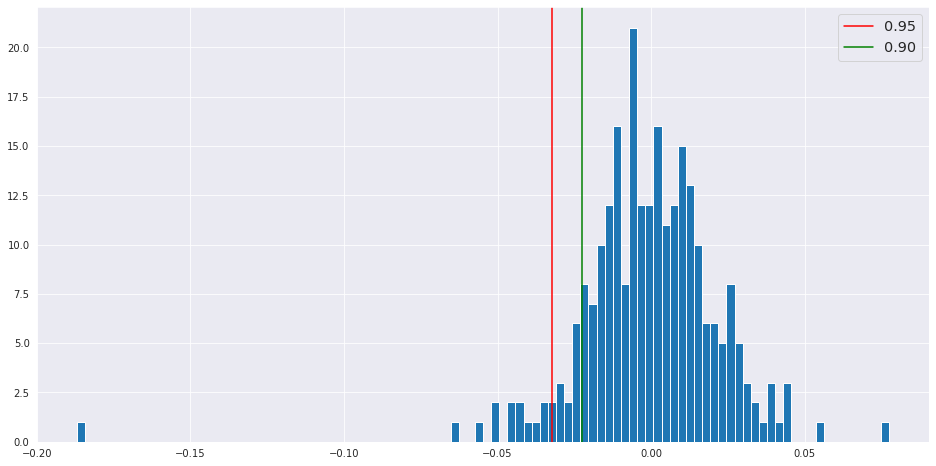

In [ ]:
stocks['SBER']['Returns'].hist(bins=100,figsize=(16,8))
plt.axvline(sorted(lst)[int(len(lst)*0.05+1)], c='r', label = '0.95')
plt.axvline(sorted(lst)[int(len(lst)*0.1+1)], c='g', label = '0.90')
plt.legend(loc='upper right', fontsize = 'x-large')
plt.show()

$\gamma = 0.95$ 

Это означает, что с вероятностью 95% наша худшая дневная потеря не превысит 3,2%. Если у нас есть инвестиции в размере 1 миллиона рублей, наша однодневная 5% -ная VaR составляет 0,032 * 1 000 000 = 32 000.

$ X = -R $

In [ ]:
lst = list(stocks['SBER']['Losses'].dropna())
sorted(lst)[int(len(lst)*0.95+1)]

0.036030857755714685

In [ ]:
lst = list(stocks['SBER']['Losses'].dropna())
sorted(lst)[int(len(lst)*0.90+1)]

0.02437466673716049

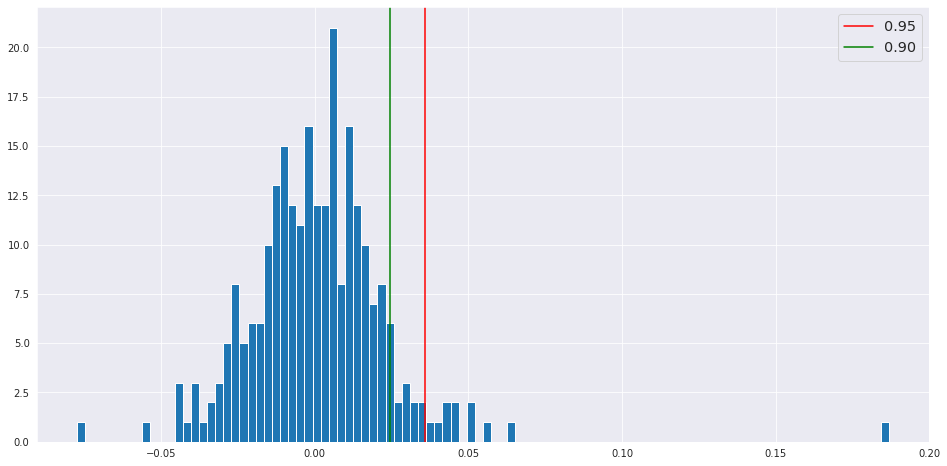

In [ ]:
stocks['SBER']['Losses'].hist(bins=100,figsize=(16,8))
plt.axvline(sorted(lst)[int(len(lst)*0.95+1)], c='r', label = '0.95')
plt.axvline(sorted(lst)[int(len(lst)*0.90+1)], c='g', label = '0.90')
plt.legend(loc='upper right', fontsize = 'x-large')
plt.show()

In [ ]:
losses_95 = {}
losses_90 = {}
for key, value in stocks.items():
  lst = list(stocks[key]['Losses'].dropna())
  var = sorted(lst)[int(len(lst)*0.95+1)] 
  losses_95[key] = abs(var)*1000000

  lst = list(stocks[key]['Losses'].dropna())
  var = sorted(lst)[int(len(lst)*0.90+1)] 
  losses_90[key] = abs(var)*1000000


In [ ]:
key_min = min(losses_95.keys(), key=(lambda k: losses_95[k]))
key_min

'RTKM_p'

In [ ]:
key_min = min(losses_90.keys(), key=(lambda k: losses_90[k]))
key_min

'RTKM_p'

In [ ]:
losses_95 = {}
losses_90 = {}
for key, value in stocks.items():
  lst = list(stocks[key]['Returns'].dropna())
  var = sorted(lst)[int(len(lst)*0.05+1)] 
  losses_95[key] = abs(var)*1000000

  lst = list(stocks[key]['Returns'].dropna())
  var = sorted(lst)[int(len(lst)*0.1+1)] 
  losses_90[key] = abs(var)*1000000


In [ ]:
key_min = min(losses_95.keys(), key=(lambda k: losses_95[k]))
key_min

'RTKM_p'

In [ ]:
key_min = min(losses_90.keys(), key=(lambda k: losses_90[k]))
key_min

'RTKM_p'

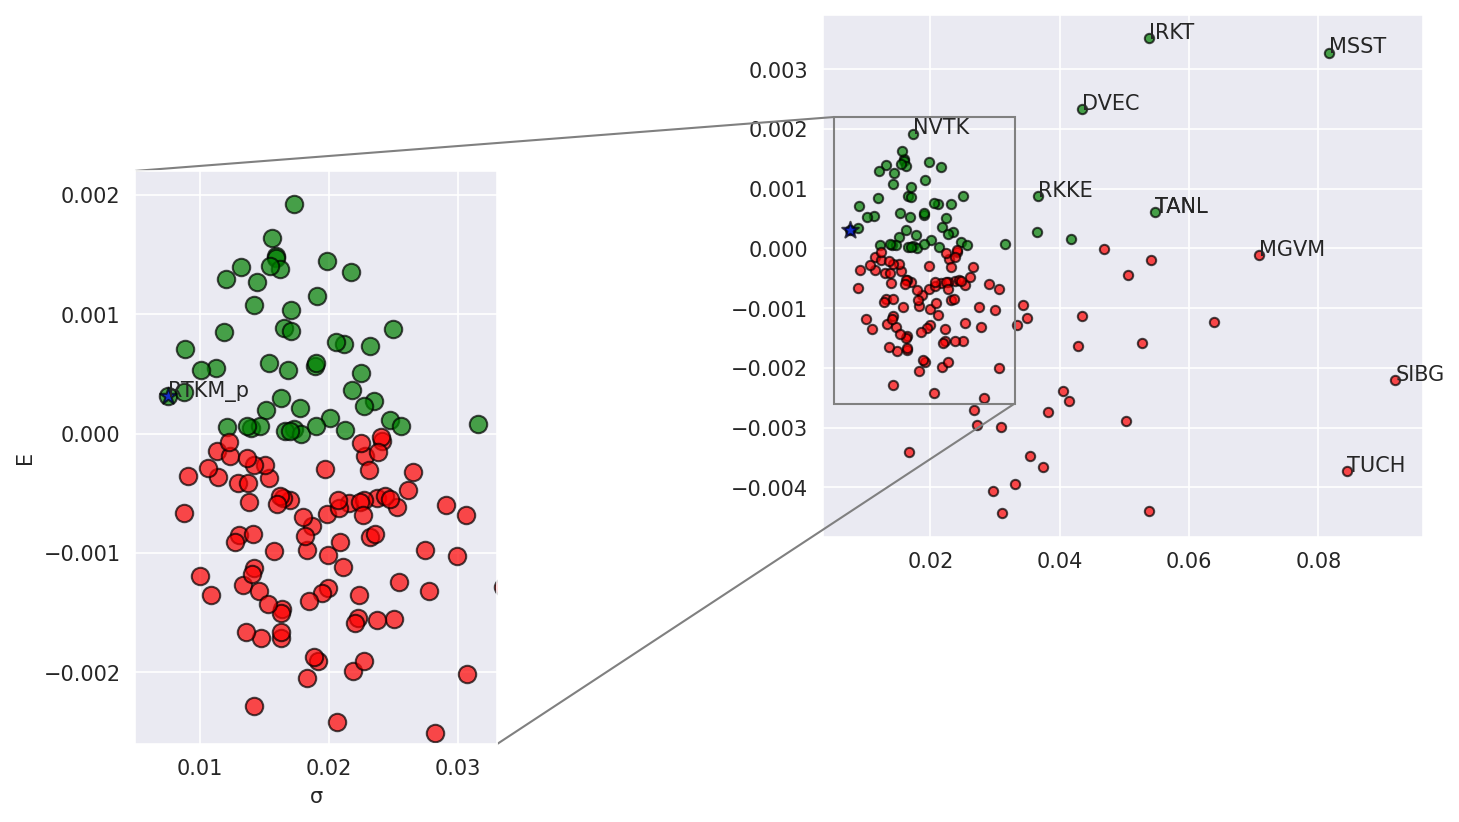

In [ ]:
R = getR(stocks)
D = getD(R)
E = getE(R)
draw(getD(R), getE(R), D['RTKM_p'], E['RTKM_p'] )

**Для портфеля с равными долями**

Вычислить обратное к нормальному кумулятивному распределению (PPF) с заданным доверительным интервалом, стандартным отклонением и средним значением, предполагая нормальное распределение

In [ ]:
from scipy.stats import norm
Z = abs(norm.ppf(0.95))
VaR = mean - Z * risk
VaR

-0.012407446021864289

In [ ]:
Z = abs(norm.ppf(0.90))
VaR = mean - Z * risk
VaR

-0.009795911383612313

In [ ]:
new_R = list(R.values())

In [ ]:
portfolio_returns = [new_R[:,x].mean() for x in range(0, new_R.shape[1])]
sorted(portfolio_returns)[int(len(portfolio_returns)*0.05+1)]

-0.009869248803657039

In [ ]:
portfolio_returns = np.dot(weights.T, new_R).reshape(-1,)
sorted(portfolio_returns)[int(len(portfolio_returns)*0.05+1)]

-0.009869248803657043

In [ ]:
portfolio_returns = [new_R[:,x].mean() for x in range(0, new_R.shape[1])]
sorted(portfolio_returns)[int(len(portfolio_returns)*0.1+1)]

-0.007444032428172483

Это означает, что с вероятностью 95% наша худшая дневная потеря не превысит 1,2%. Если у нас есть инвестиции в размере 1 миллиона рублей, наша однодневная 5% -ная VaR составляет 0,012 * 1 000 000 = 12 000.

**Для индекса рынка MOEX**



In [ ]:
R_indices = getR(indices)

In [ ]:
sorted(R_indices['MOEX'])[int(len(R_indices['MOEX'])*0.05+1)]

-0.014582911601866755

In [ ]:
sorted(R_indices['MOEX'])[int(len(R_indices['MOEX'])*0.1+1)]

-0.011647782192858003

## Задание 6

<em> Выберите несколько интересных (значимых)  активов рынка.   Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)?  Поищите научные подходы к ответу на этот вопрос (проверка гипотезы о случайности, Ивченко Г.И. Медведев Ю.И. Введение в математическую статистику) </em>

---


Для того, чтобы лучше понять к какому распределению могут соответствовать доходности посмотрим на гистограммы доходностей для различных активов:  

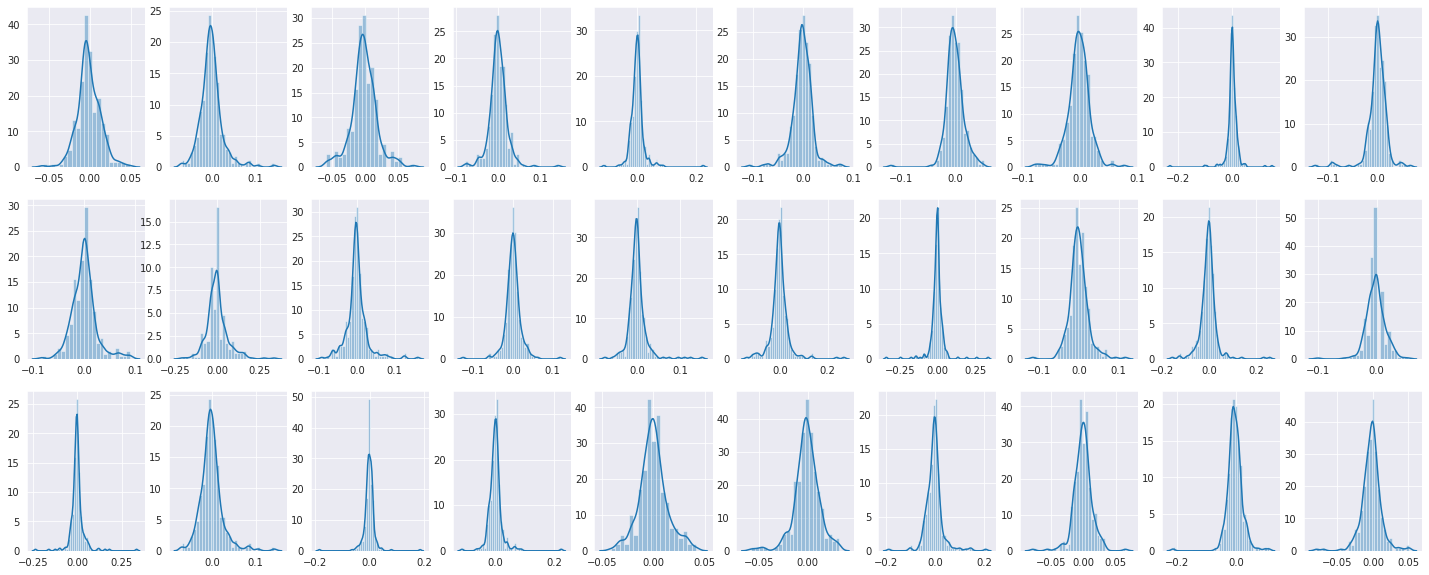

In [ ]:
R = getR(stocks)
E, D = getE(R), getD(R)

fig1, axs1 = plt.subplots(nrows=3, ncols=10, figsize=(25, 10))

for _ in range(3):
    for __ in range(10):
        i = np.random.randint(0, len(stocks.keys()))
        st = list(stocks.keys())
        sns.distplot(R[st[i]], ax=axs1[_][__])

<b><em>Наблюдаемые доходности некоторых активов похожи на выборки нормального распределения.</em></b>

Аналогично для объемов продаж:

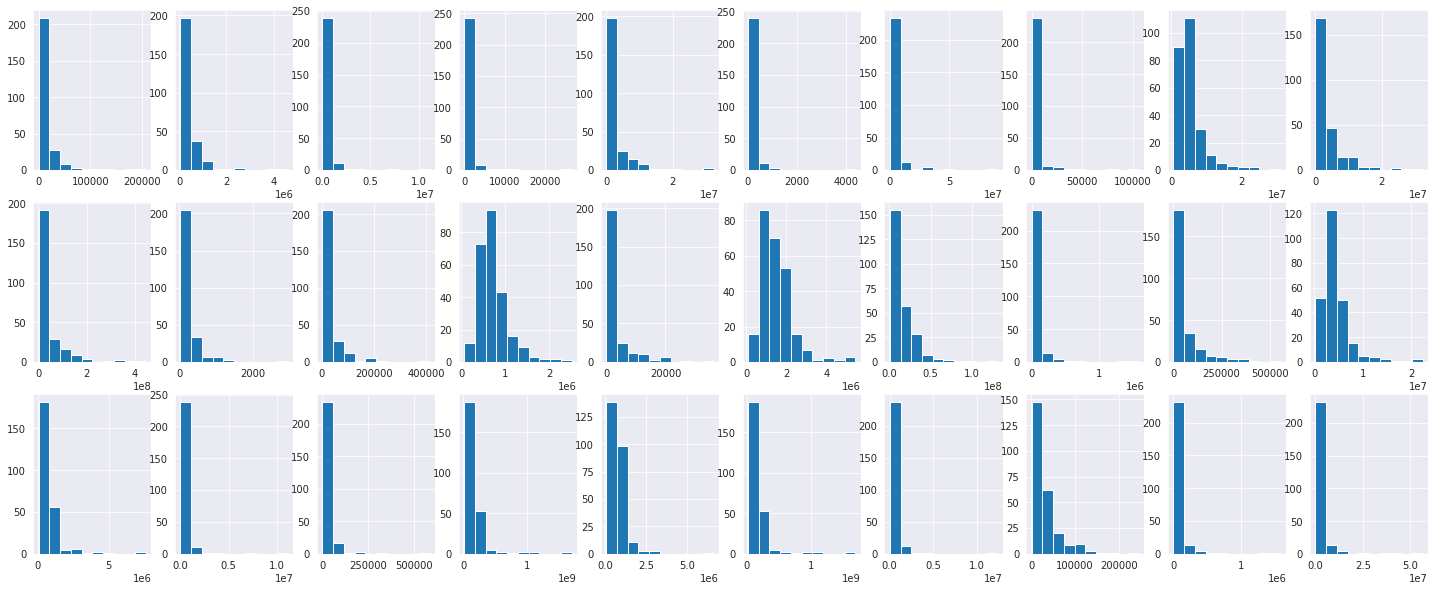

In [ ]:
fig1, axs1 = plt.subplots(nrows=3, ncols=10, figsize=(25, 10))

for _ in range(3):
    for __ in range(10):
        i = np.random.randint(0, len(stocks.keys()))
        st = list(stocks.keys())
        axs1[_][__].hist(stocks[st[i]]['Volume'])

<b><em>Наблюдаемые объемы продаж некоторых активов похожи на выборки экспоненциального распределения.</em></b>

Проверим наши предположения с помощью процедуры проверки статистических гипотеза, а именно с помощью теста Андерсона — Дарлинга. 
Детальное описание теста здесь:  https://web.archive.org/web/20150630110326/http://instatmy.org.my/downloads/e-jurnal%202/3.pdf

### Результаты для доходностей

В таблице приведены активы, для которых гипотезы (о том, что доходности распределены нормально) были не отвергнуты для определенного уровня значимости. 

In [ ]:
R = getR(stocks)

results = []

for key, value in R.items():
    stat, critical_valueslist, significance_levellist = anderson(value, 'norm')
    for i in range(len(significance_levellist)):
        if stat < critical_valueslist[i]:
            full_name = "-"
            sec = "-"
            if key in stocks_info:
                full_name, otr, sec = list(stocks_info[key])
            results.append([key, full_name, sec, significance_levellist[i]/100.])

pd.DataFrame(results, columns=["Тикет", "Полное имя", "Сектор", "Уровень значемости"])

,Тикет,Полное имя,Сектор,alpha
0,GAZP,Газпром ПАО (GAZP),Сектор Коммунальные услуги,0.050
1,GAZP,Газпром ПАО (GAZP),Сектор Коммунальные услуги,0.025
2,GAZP,Газпром ПАО (GAZP),Сектор Коммунальные услуги,0.010
3,MAGN,ММК ОАО (MAGN),Сектор Сырье,0.010
4,NLMK,Новолипецкий MK (NLMK),Сектор Сырье,0.010
5,SNGS,Surgutneftegaz PAO (SNGS),Сектор Энергетика,0.050
6,SNGS,Surgutneftegaz PAO (SNGS),Сектор Энергетика,0.025
7,SNGS,Surgutneftegaz PAO (SNGS),Сектор Энергетика,0.010
8,SNGS_p,Сургутнефтегаз (прив.) (SNGS_p),Сектор Энергетика,0.010
9,TATN,ОАО Татнефть (TATN),Сектор Энергетика,0.010


<b>Вывод:</b> при уровне значимости 0.01 гипотеза о нормальности распределения доходностей не отвергнута для 11 активов из 172.

### Результаты для объемов продаж

В таблице приведены активы, для которых гипотезы (о том, что объемы продаж имеют экспоненциальное распределение) были не отвергнуты для определенного уровня значимости. 

In [ ]:
results = []

for key, value in stocks.items():
    stat, critical_valueslist, significance_levellist = anderson(value['Volume'], 'expon')
   
    for i in range(len(significance_levellist)):
        if stat < critical_valueslist[i]:
            full_name = "-"
            sec = "-"
            if key in stocks_info:
                full_name, otr, sec = list(stocks_info[key])
            results.append([key, full_name, sec, significance_levellist[i]/100.])

pd.DataFrame(results, columns=["Тикер", "Полное имя", "Сектор", "alpha"])

,Тикер,Полное имя,Сектор,alpha
0,CHMK,Челябинский металлургический комбинат (CHMK),Сектор Сырье,0.100
1,CHMK,Челябинский металлургический комбинат (CHMK),Сектор Сырье,0.050
2,CHMK,Челябинский металлургический комбинат (CHMK),Сектор Сырье,0.025
3,CHMK,Челябинский металлургический комбинат (CHMK),Сектор Сырье,0.010
4,HIMC_p,Химпром (прив.) (HIMC_p),Сектор Сырье,0.150
5,HIMC_p,Химпром (прив.) (HIMC_p),Сектор Сырье,0.100
6,HIMC_p,Химпром (прив.) (HIMC_p),Сектор Сырье,0.050
7,HIMC_p,Химпром (прив.) (HIMC_p),Сектор Сырье,0.025
8,HIMC_p,Химпром (прив.) (HIMC_p),Сектор Сырье,0.010
9,NKNC,Нижнекамскнефтехим (NKNC),Сектор Сырье,0.050


<b>Вывод:</b> при уровне значимости 0.01 гипотеза, что объемы продаж имеют экспоненциальное распределение не отвергнуты для 3 активов из 172.

## Задание 7
<em> Выберите несколько интересных (значимых)  активов рынка из разных производственных секторов.   В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы. <em>
    
---


In [ ]:
stocks_overview = []
R = getR(stocks)
E = getE(R)
D = getD(R)

for key, value in stocks.items():
  try:
    full_name = stocks_info[key][0]
    sec = stocks_info[key][1]
    sector = stocks_info[key][2]
    stocks_overview.append([full_name, sector[sector.find(' '):], int(value['Volume'].mean()), E[key], D[key]])
  except:
    stocks_overview.append([key, "-", int(value['Volume'].mean()), E[key], D[key]])
    
df = pd.DataFrame(stocks_overview, columns=["Полное имя", "Сектор", "Средний объем", "Средняя доходность", "std"])
df.sort_values(by="Средний объем", ascending=False, ignore_index=True)[:40]

,Полное имя,Сектор,Средний объем,Средняя доходность,std
0,Банк ВТБ (ОАО) (VTBR),Финансы,22017168000,-0.001502,0.016253
1,ТГК №1 ОАО (TGKA),Коммунальные услуги,1696559015,-0.001661,0.016292
2,ФСК ЕЭС ОАО (FEES),Коммунальные услуги,1414855721,-0.000373,0.015374
3,ОАО РусГидро (HYDR),Коммунальные услуги,533275620,-0.001660,0.013609
4,ТГК №2 ОАО (TGKB),Коммунальные услуги,524750984,-0.002011,0.030644
5,Квадра (TGKD),Коммунальные услуги,484648823,-0.000526,0.024352
6,Росгосстрах (RGSS),Финансы,227150840,-0.003668,0.037331
7,Российские сети ОАО (RSTI),Коммунальные услуги,167971966,-0.000298,0.019714
8,МРСК Волги ОАО (MRKV),Коммунальные услуги,123804607,-0.000264,0.015077
9,Интер РАО ЕЭС ОАО (IRAO),Коммунальные услуги,91143998,0.000532,0.016835


Были выбраны 4 актива из разных секторов :


*   Банк ВТБ (ОАО) : Финансы
*   ОАО Аэрофлот : Транспорт
*   Корпорация Иркут: Средства производства
*   Surgutneftegaz PAO : Энергетика



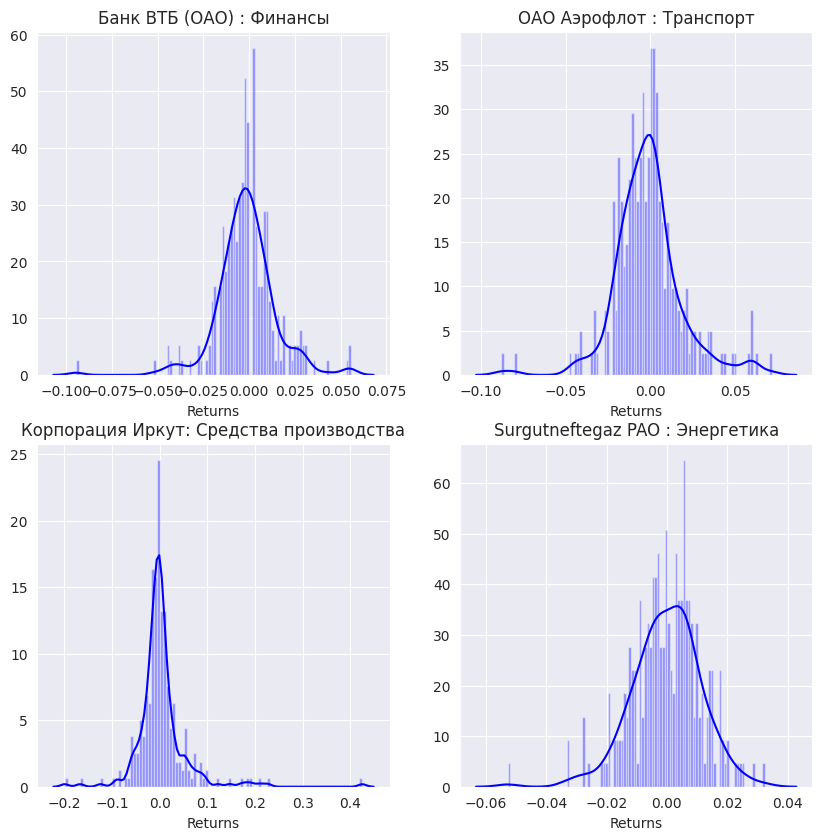

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi = 100)
sns.distplot(stocks['VTBR']['Returns'].dropna(), bins=100, color='blue', ax = axs[0][0])
sns.distplot(stocks['AFLT']['Returns'].dropna(), bins=100, color='blue', ax = axs[0][1])
sns.distplot(stocks['IRKT']['Returns'].dropna(), bins=100, color='blue', ax = axs[1][0])
sns.distplot(stocks['SNGS']['Returns'].dropna(), bins=100, color='blue', ax = axs[1][1])
axs[0][0].title.set_text('Банк ВТБ (ОАО) : Финансы')
axs[0][1].title.set_text('ОАО Аэрофлот : Транспорт')
axs[1][0].title.set_text('Корпорация Иркут: Средства производства')
axs[1][1].title.set_text('Surgutneftegaz PAO : Энергетика')


На графиках представлены распределения доходностей выбранных активов вместе с визуализацией плотности вероятности переменных

Для более точной оценки посчитаем ассиметрию и эксцесс для полученных распределений

Коэффициент эксцесса задаётся формулой:

$$\gamma _{2}={\frac  {\mu _{4}}{\sigma ^{4}}}-3.$$



Коэффициент асимметрии задаётся формулой:


$$\gamma _{1}={\frac  {\mu _{3}}{\sigma ^{3}}}.$$

In [ ]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [ ]:
skew_kurtosis = pd.DataFrame({
'Skew_Kurtosis': ['Aссиметрия', 'Эксцесс'],
'VTBR': [stocks['VTBR']['Returns'].dropna().skew(), stocks['VTBR']['Returns'].dropna().kurtosis()],
'AFLT': [stocks['AFLT']['Returns'].dropna().skew(), stocks['AFLT']['Returns'].dropna().kurtosis()],
'IRKT': [stocks['IRKT']['Returns'].dropna().skew(), stocks['IRKT']['Returns'].dropna().kurtosis()],
'SNGS': [stocks['SNGS']['Returns'].dropna().skew(), stocks['SNGS']['Returns'].dropna().kurtosis()],
'Norm': [0, 0]
})
from IPython.display import HTML
HTML(skew_kurtosis.to_html(index=False))

Skew_Kurtosis,VTBR,AFLT,IRKT,SNGS,Norm
Aссиметрия,-0.386269,0.266864,2.578341,-0.486099,0
Эксцесс,5.448362,3.463447,17.869796,1.683992,0


Для VTBR и SNGS распределение с негативной асимметрией, как говорят, левосторонняя или со сдвигом влево, показывает, что остатки на левой стороне функции распределения больше, чем на правой, а большое значение вероятности находится справа от средней величины.

Нормальное распределение имеет значение эксцесса равным нулю. Распределение с положительным эксцессом называется островершинным распределением, в то время, как распределение с негативной асимметрией, называются плосковершинным

Высший эксцесс отражает большую дисперсию, это является результатом крайне редких отклонений, в отличие от частых отклонений небольших размеров. В результате островершинное распределение имеет более высокий пик около средней величины по сравнению с нормальным распределением, то есть, плотность вероятности концентрируется вокруг средней величины и в хвостах.

Эксцесс с островершинным распределением опасен, так как толстые хвосты (для точности: толстые отрицательные хвосты) приводят к огромным убыткам, которые могут часто возникать

**Тест Колмогорова-Смирнова**

Критерий Колмогорова-Смирнова используется для проверки гипотезы $H_0$: "случайная величина $X$ имеет распределение $F(x)$".

Статистика критерия определяется выражением:

$$D_n=\sup_x |F_n(x)-F(x)|.$$

При использовании критерия для проверки нормальности

$$D_n^*=D_n(\sqrt{n} - 0.01 + \frac{0.85}{\sqrt{n}})$$

In [ ]:
import scipy
from scipy.stats import kstest

In [ ]:
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['VTBR']['Returns'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
v = kstest(stocks['VTBR']['Returns'].dropna(), norm_spy.cdf)
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['AFLT']['Returns'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
a = kstest(stocks['AFLT']['Returns'].dropna(), norm_spy.cdf)
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['IRKT']['Returns'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
r = kstest(stocks['IRKT']['Returns'].dropna(), norm_spy.cdf)
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['SNGS']['Returns'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
s = kstest(stocks['SNGS']['Returns'].dropna(), norm_spy.cdf)

In [ ]:
results = pd.DataFrame({
'Test results': ['statistic', 'p_value'],
'VTBR': [v[0], v[1]],
'AFLT': [a[0], a[1]],
'IRKT': [r[0], r[1]],
'SNGS': [s[0], s[1]],
})
from IPython.display import HTML
HTML(results.to_html(index=False))

Test results,VTBR,AFLT,IRKT,SNGS
statistic,0.086440,0.106236,1.886603e-01,0.038858
p_value,0.042288,0.005972,2.172660e-08,0.837754


Отклонение от нормального распределения считается существенным при значении р_value < 0,05

**Аналогично для объема продаж**

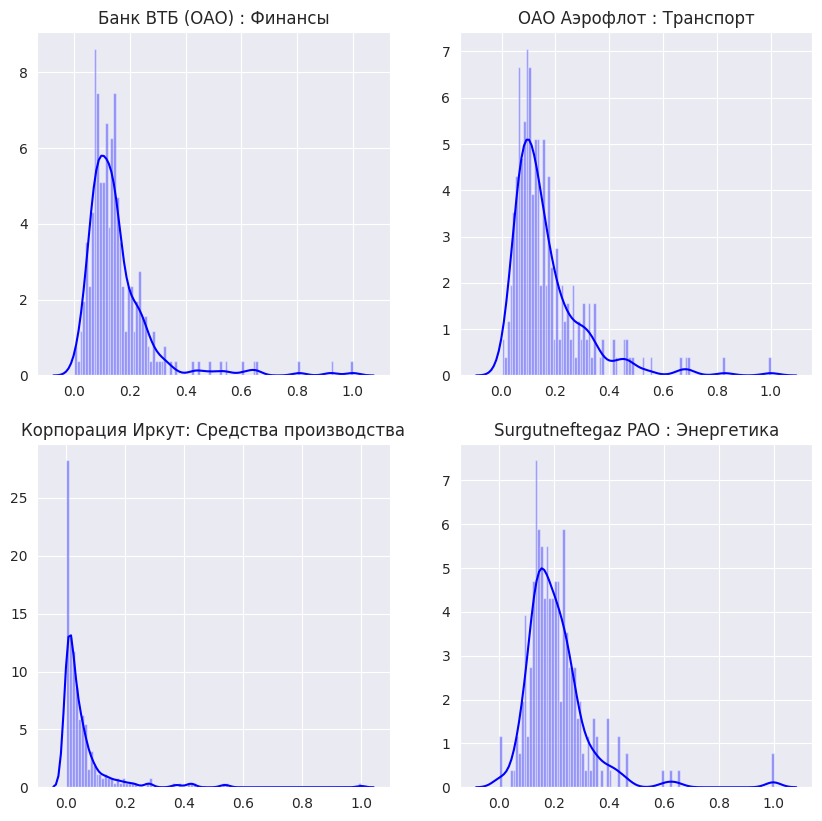

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi=100)
sns.distplot(norml(stocks['VTBR']['Volume'].dropna()), bins=100, color='blue', ax = axs[0][0])
sns.distplot(norml(stocks['AFLT']['Volume'].dropna()), bins=100, color='blue', ax = axs[0][1])
sns.distplot(norml(stocks['IRKT']['Volume'].dropna()), bins=100, color='blue', ax = axs[1][0])
sns.distplot(norml(stocks['SNGS']['Volume'].dropna()), bins=100, color='blue', ax = axs[1][1])
axs[0][0].title.set_text('Банк ВТБ (ОАО) : Финансы')
axs[0][1].title.set_text('ОАО Аэрофлот : Транспорт')
axs[1][0].title.set_text('Корпорация Иркут: Средства производства')
axs[1][1].title.set_text('Surgutneftegaz PAO : Энергетика')

In [ ]:
skew_kurtosis = pd.DataFrame({
'Skew_Kurtosis': ['Aссиметрия', 'Эксцесс'],
'VTBR': [stocks['VTBR']['Volume'].dropna().skew(), stocks['VTBR']['Volume'].dropna().kurtosis()],
'AFLT': [stocks['AFLT']['Volume'].dropna().skew(), stocks['AFLT']['Volume'].dropna().kurtosis()],
'IRKT': [stocks['IRKT']['Volume'].dropna().skew(), stocks['IRKT']['Volume'].dropna().kurtosis()],
'SNGS': [stocks['SNGS']['Volume'].dropna().skew(), stocks['SNGS']['Volume'].dropna().kurtosis()],
'Norm': [0, 0]
})
from IPython.display import HTML
HTML(skew_kurtosis.to_html(index=False))

Skew_Kurtosis,VTBR,AFLT,IRKT,SNGS,Norm
Aссиметрия,3.377141,2.450908,4.735693,3.005361,0
Эксцесс,15.381216,8.660479,31.565405,15.829421,0


In [ ]:
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['VTBR']['Volume'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
v = kstest(stocks['VTBR']['Volume'].dropna(), norm_spy.cdf)
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['AFLT']['Volume'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
a = kstest(stocks['AFLT']['Volume'].dropna(), norm_spy.cdf)
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['IRKT']['Volume'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
r = kstest(stocks['IRKT']['Volume'].dropna(), norm_spy.cdf)
loc_norm, scale_norm = scipy.stats.norm.fit(stocks['SNGS']['Volume'].dropna())
norm_spy = scipy.stats.norm(loc=loc_norm, scale=scale_norm)
s = kstest(stocks['SNGS']['Volume'].dropna(), norm_spy.cdf)

In [ ]:
results = pd.DataFrame({
'Test results': ['statistic', 'p_value'],
'VTBR': [v[0], v[1]],
'AFLT': [a[0], a[1]],
'IRKT': [r[0], r[1]],
'SNGS': [s[0], s[1]],
})
from IPython.display import HTML
HTML(results.to_html(index=False))

Test results,VTBR,AFLT,IRKT,SNGS
statistic,1.916013e-01,1.713279e-01,2.831234e-01,0.132666
p_value,1.130763e-08,5.154712e-07,1.406860e-18,0.000225


## Задание 8
<em> Исследовать зависимости (выборочно) между доходностями различных активов с помощью техники анализа зависимостей. Сделайте анализ зависимостей между парами активов для активов из одного производственного сектора и для активов из разных производственных секторов. Сделайте анализ зависимости (выборочно) между доходностями и объемами продаж одного актива. Рассмотрите активы из разных производственных секторов. </em>

---


Рассмотрим топ 20 самых ликвидных активов:

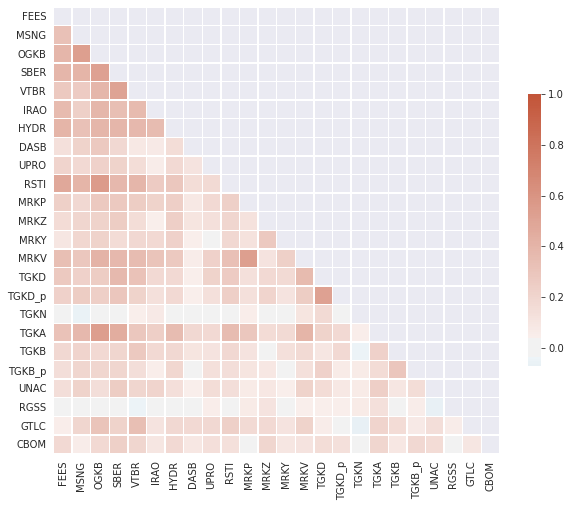

In [ ]:
df = getStocksOverview(stocks)
keys = df.sort_values(by="Средний объем", ascending=False, ignore_index=True)[:20]['Тикер']
R = getR(stocks)

d = pd.DataFrame(data={key: R[key] for key in keys})
corr = d.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<b>Вывод:</b> сложно сделать вывод о корреляции между активами, так как коэффициенты колеблется в основном между [0.1, 0.2]; но такие активы как TGKN и RGSS явно выделяются, они слабее всего коррелируют с другими активами. 

 

Функция scipy.stats.pearsonr возвращает корреляционной коэффициент Пирсона и p-value для проверки отсутствия корреляции (при вычислении p-value считается, что данные распределены нормально) между данными. 
Проверим на отсутствие корреляции между доходностями активов, для которых подтвердилась гипотеза о нормальном распределение доходностей. 

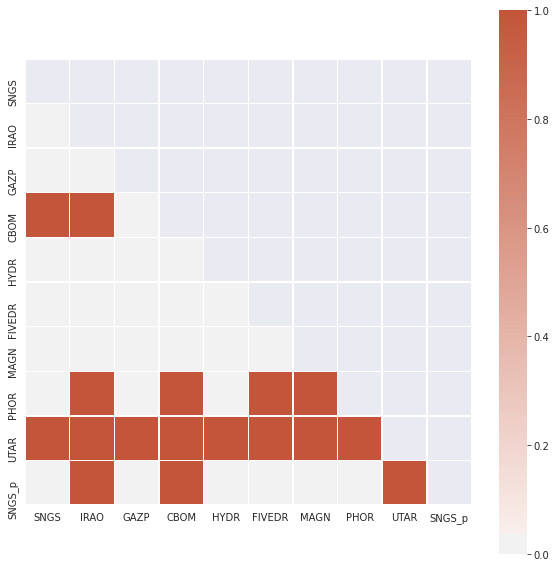

In [ ]:
keys = {'GAZP', 'MAGN', 'SNGS', 'SNGS_p', 'IRAO', 'CBOM', 'UTAR', 'FIVEDR', 'HYDR', 'PHOR'}
R20 = {key: R[key] for key in keys}

corr = []
for key, value in R20.items():
  lst = []
  for key2, value2 in R20.items():
    c, p = stats.pearsonr(value, value2)
    if p > 0.01:
      lst.append(True)
    else:
      lst.append(False)
  corr.append(lst)

corr = pd.DataFrame(corr, index=R20.keys(), columns=R20.keys())
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5)
plt.show()

<b>Вывод:</b> UTAR (Сектор Транспорт) слабо связана со всеми активами из списка. Странно, что результаты для SNGS и SNGS_p не совпали. Нестранно, что гипотеза об отсутствие корреляции между парами активов из одного сектора, а именно сектора коммунальных услуг (GAZP, IRAO, HYDR), не подтвердилась. 

Рассмотрим два сектора - энергетика и финансы:

In [ ]:
stocks_electorenergy = {}

for key, value in stocks_info.items():
    if value[2] == "Сектор Энергетика":
        if key in stocks:
            stocks_electorenergy[key] = stocks[key]

In [ ]:
stocks_fin = {}

for key, value in stocks_info.items():
    if value[2] == "Сектор Финансы":
        if key in stocks:
            stocks_fin[key] = stocks[key]

Коэффициенты корреляции Пирсона для сектора "Финансы": 

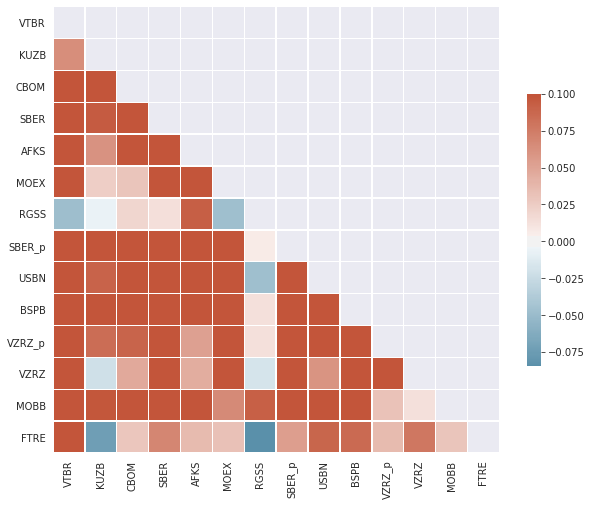

In [ ]:
d = pd.DataFrame(data=getR(stocks_fin))

corr = d.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<b>Вывод:</b> между большинста пар активов наблюдается сильна корелляция. Выделяется актив RGSS (Rosgosstrakh), коэффициенты корреляции с которым ближе всего к нулю.

Коэффициент корреляции Пирсона для сектора "Энергетика": 

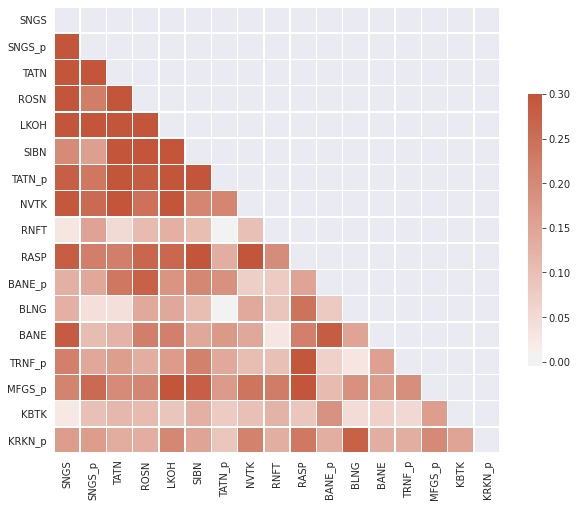

In [ ]:
d = pd.DataFrame(data=getR(stocks_electorenergy))

corr = d.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<b>Вывод:</b> наблюдается сильная корреляция (причем положительная) между всеми парами активов, за исключением некоторых пар. Выделяются BLNG и KBTK, оба актива из угледобывающей промышленности и причем единственные из нашего списка относятся к данной отрасли, в то время как остальные активы из нефтегазовой промышленности. 

 

Корелляционые коэффициенты для пар активов из сектора "Энергетика" (ось OX) и "Финансы" (ось OY):

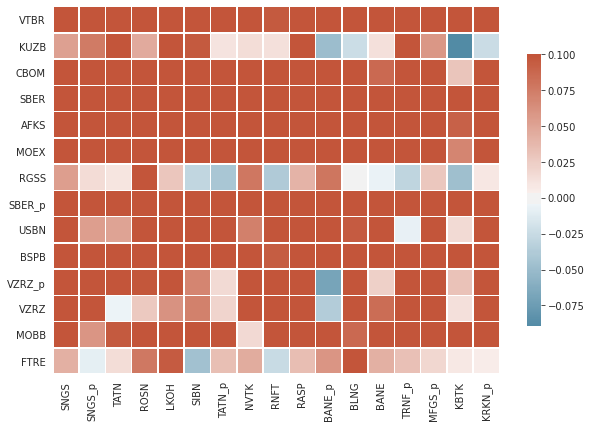

In [ ]:
d = pd.DataFrame(data=getR(dict(stocks_electorenergy, **stocks_fin)))

corr = d.corr()
corr = corr.loc[stocks_fin.keys(), stocks_electorenergy.keys()]

f, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<b>Вывод:</b> почти все пары активов имеют сильную корреляция, выделяются активы KUZB, RGSS, FTRE, которые слабо взаимосвязаны с активами другого сектора и также слабо взаимосвязаны с активами из своего сектора. 

<b>Вывод:</b> 

 

## Задание 9
<em>
Бонус. Попробуйте найти что-нибудь интересное (необычное) на вашем рынке. Используйте любые известные вам методы анализа данных (data mining). 
<em>

---

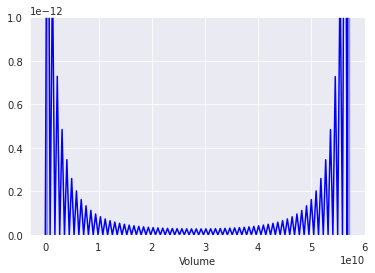

In [ ]:
sns.distplot(stocks['RGSS']['Volume'].dropna(), bins=100, color='blue')

In [ ]:
df = pd.DataFrame({
    'RGSS':stocks['RGSS']['Returns'], 
    'VTBR':stocks['VTBR']['Returns'],
    'GAZP':stocks['GAZP']['Returns']
    }, index=stocks['AFLT'].index
    )

In [ ]:
df.corr()

,RGSS,VTBR,GAZP
RGSS,1.000000,-0.048438,0.041643
VTBR,-0.048438,1.000000,0.405166
GAZP,0.041643,0.405166,1.000000


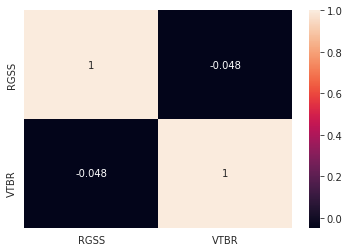

In [ ]:
sns.heatmap(df.corr(),annot=True)

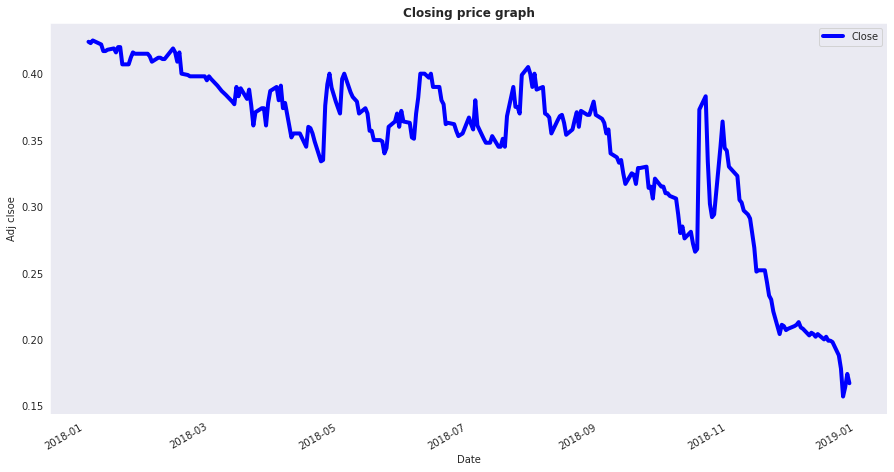

In [ ]:
stocks['RGSS']['Close'].plot(legend=True,color='Blue',figsize=(15,8),linewidth=4)
plt.title("Closing price graph",weight= 'bold')
plt.ylabel("Adj clsoe")
plt.grid()


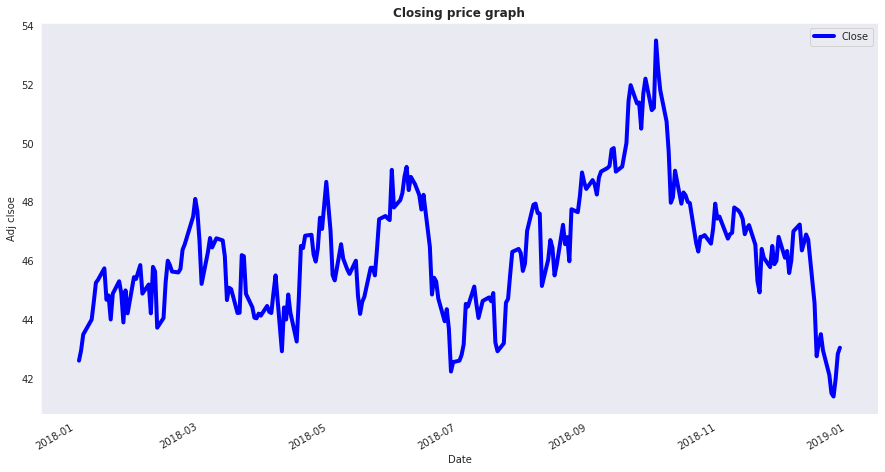

In [ ]:
stocks['MAGN']['Close'].plot(legend=True,color='Blue',figsize=(15,8),linewidth=4)
plt.title("Closing price graph",weight= 'bold')
plt.ylabel("Adj clsoe")
plt.grid()

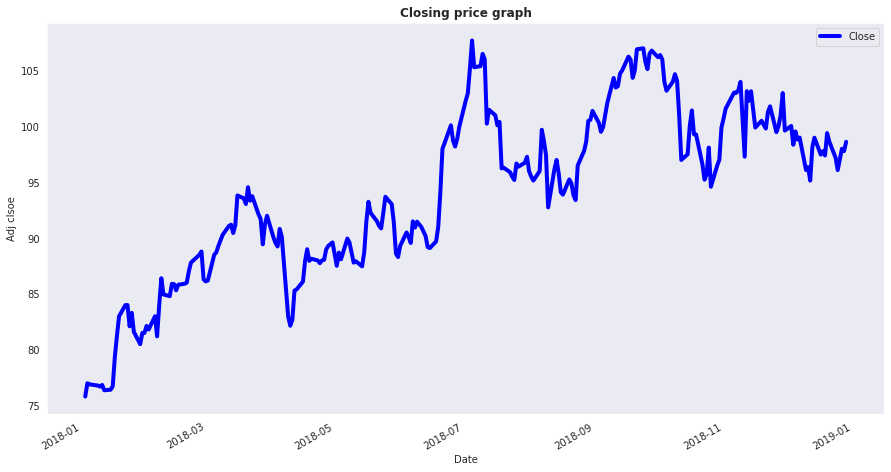

In [ ]:
stocks['ALRS']['Close'].plot(legend=True,color='Blue',figsize=(15,8),linewidth=4)
plt.title("Closing price graph",weight= 'bold')
plt.ylabel("Adj clsoe")
plt.grid()

In [ ]:
df = pd.Dataframe()

In [ ]:
sns.heatmap(return.corr(),annot=True)

In [ ]:
d = pd.DataFrame(data=getR(stocks))

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,6), dpi=150)
sns.heatmap(d.dropna(),annot=True,)